In [76]:
import sqlite3
import csv
import numpy as np
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

In [77]:
global REQUEST
global R
global ALPHA_LIST

REQUEST = {'mood': 0, 'body': 0, 'money': -5, 'time': 0}
R = 20
#ALPHA_LIST = [0, 0.25, 0.5, 0.75, 1]
range_N = 4 # + 1
ALPHA_LIST = [i/range_N for i in range(0, range_N+1)]

# REQUESTとALPHA_LISTの内容を表示
print('REQUEST:', REQUEST)
print('ALPHA_LIST:', ALPHA_LIST)

REQUEST: {'mood': 0, 'body': 0, 'money': -5, 'time': 0}
ALPHA_LIST: [0.0, 0.25, 0.5, 0.75, 1.0]


In [78]:
# データベースに接続
conn = sqlite3.connect("recipe.db")
cursor = conn.cursor()

# データベースからデータを取得
cursor.execute('SELECT * FROM recipe')
result = cursor.fetchall()

# 取得したデータをリストに格納
recipe_list = []
for row in result:
    recipe_list.append(list(row))

# データベース接続を閉じる
cursor.close()
conn.close()

In [79]:
# レシピデータの気分と分類を取得し標準化を行う

# レシピデータの気分のラベルを取得['mood', 'body', 'money', 'time']
moods = recipe_list[0][4:8]

# レシピデータの気分と分類を取得
recipe_list_syusyoku = []
recipe_list_syusai = []
recipe_list_hukusai = []
recipe_list_mood = []
recipe_list_body = []
recipe_list_money = []
recipe_list_time = []

# レシピデータの気分と分類をリストに格納(先頭行のラベルを除く)
for row in recipe_list[1:]:
    recipe_list_syusyoku.append(float(list(row)[1]))  # 「主食」の行のみを抽出
    recipe_list_syusai.append(float(list(row)[2]))    # 「主菜」の行のみを抽出
    recipe_list_hukusai.append(float(list(row)[3]))   # 「副菜」の行のみを抽出
    recipe_list_mood.append(float(list(row)[4]))      # 「精神」の行のみを抽出
    recipe_list_body.append(float(list(row)[5]))      # 「身体」の行のみを抽出
    recipe_list_money.append(float(list(row)[6]))     # 「経済」の行のみを抽出
    recipe_list_time.append(float(list(row)[7]))      # 「時間」の行のみを抽出

# レシピデータの時間の値を標準化
recipe_list_time_std = preprocessing.scale(recipe_list_time)

# レシピデータの気分の値を標準化した値をリストに格納
recipe_moods_std = [recipe_list_mood, recipe_list_body, recipe_list_money, recipe_list_time_std]

# POSTメソッドから取得した気分の値を取得
# (例)  [('mood', '-1'), ('body', '-2'), ('money', '-2'), ('time', '1')]
mood_values = [float(REQUEST[mood]) for mood in moods]


In [80]:
# ユーザの気分の値とレシピデータの気分の値のユークリッド距離を算出
squared_diff = []

for mood_index, mood_value in enumerate(mood_values):
    if mood_value != 0:

        diff_mood = np.array(recipe_moods_std[mood_index]) - mood_value # レシピデータの気分とPOSTメソッドから取得したmoodの値の差を計算
        squared_diff_mood = np.square(diff_mood)                        # 差の2乗を計算
    else:
        # スライダーが0を選択しているときはユークリッド距離を計算しない
        squared_diff_mood = np.zeros(len(recipe_moods_std[0]), dtype=float)
    
    squared_diff.append(squared_diff_mood)

# 各列の合計を求める
squared_diff_columns_sum = np.sum(squared_diff, axis=0)

# 各要素の平方根を求める
euclidean_distance_list = np.sqrt(squared_diff_columns_sum)

In [81]:
# スコアが0となるとき逆数変換したスコアがinfとなる問題を回避するため、0の値を最小値の半分に置換する
# euclidean_distance_listの0より大きい最小値を取得
min_euclidean_distance = np.min(euclidean_distance_list[np.nonzero(euclidean_distance_list)])

# min_euclidean_distanceの値を半分にする
min_euclidean_distance_half = min_euclidean_distance / 2

# euclidean_distance_listの0をmin_euclidean_distance_halfに置換
euclidean_distance_list = np.where(euclidean_distance_list==0, min_euclidean_distance_half, euclidean_distance_list)

In [82]:
# ユークリッド距離の値のリストとレシピデータのリストを結合
# 距離の値のリストとデータベースから取得したデータのリストを結合
combined_list = []
recipe_list_deleted_label = recipe_list[1:] # 先頭行のラベルを除く
for row_num in range(len(recipe_list_deleted_label)):
    recipe_list_deleted_label[row_num].append(euclidean_distance_list[row_num])
    combined_list.append(recipe_list_deleted_label[row_num])

# 距離に基づいてリストをソート(昇順)
sorted_list = sorted(combined_list, key=lambda x: x[8])

# ランキングスコアを逆数に変換
sorted_list_reciprocal = []

for i in range(len(sorted_list)):
    sorted_item_reciprocal = sorted_list[i][0:8]
    sorted_list_reciprocal.append(sorted_item_reciprocal)
    sorted_list_reciprocal[i].append(1/sorted_list[i][8])

# 多様性リランキング前のスコアを保存
sorted_list_no_reranking = sorted_list_reciprocal.copy()

In [83]:
sorted_list

[['大根サラダ', 0.0, 0.0, 0.5, -2.25, -4.5, -4.5, 10.0, 0.5],
 ['玉葱ステーキ', 0.0, 0.0, 0.5, -0.75, -0.25, -4.5, 30.0, 0.5],
 ['キャロット・ラペ', 0.0, 0.0, 0.5, -2.75, -4.5, -4.5, 10.0, 0.5],
 ['揚げ出し豆腐', 0.0, 0.5, 0.5, -3.5, -1.0, -4.0, 25.0, 1.0],
 ['青菜のおひたし', 0.0, 0.0, 0.5, -2.5, -2.75, -4.0, 20.0, 1.0],
 ['胡麻酢和え', 0.0, 0.0, 0.5, -2.25, -3.75, -4.0, 15.0, 1.0],
 ['シーザーサラダ', 0.0, 0.0, 0.5, -1.5, -2.75, -4.0, 20.0, 1.0],
 ['ペチュギムチ(白菜キムチ)', 0.0, 0.0, 0.5, -2.75, -1.75, -4.0, 30.0, 1.0],
 ['野菜の白和え(白酢和え)', 0.0, 0.0, 0.5, -2.25, -4.5, -3.75, 30.0, 1.25],
 ['なすの丸炊き', 0.0, 0.0, 0.5, -2.0, -3.0, -3.75, 40.0, 1.25],
 ['コールスロー', 0.0, 0.0, 0.5, -1.75, -3.25, -3.75, 50.0, 1.25],
 ['焼きそば', 0.5, 0.5, 0.5, 2.0, 4.25, -3.75, 10.0, 1.25],
 ['カクテキ(大根キムチ)', 0.0, 0.0, 0.5, -3.0, -2.0, -3.75, 30.0, 1.25],
 ['ほうれん草のごまあえ\t', 0.0, 0.0, 0.5, -2.75, -4.0, -3.5, 20.0, 1.5],
 ['高野豆腐の煮物', 0.0, 0.0, 0.5, -3.75, -3.5, -3.5, 10.0, 1.5],
 ['叩きごぼう', 0.0, 0.0, 0.5, -2.5, -3.0, -3.5, 10.0, 1.5],
 ['なます', 0.0, 0.0, 0.5, -1.25, -4.5, -3.

In [84]:
# ランキングスコアを正規化
# スコアだけを抽出して別のリストに格納
list_score = []
for row in sorted_list_reciprocal:
    list_score.append(row[8])

# スコアを正規化
list_score = preprocessing.minmax_scale(list_score, feature_range=(0, 1))

# 正規化したスコアをリストに戻す
normalized_score_list = []
for i in range(len(sorted_list_reciprocal)):
    normalized_score_list.append(sorted_list_reciprocal[i][0:8])
    normalized_score_list[i].append(list_score[i])

In [85]:
''' コサイン類似度は利用しない
# 多様性を考慮したリランキングを行う
# コサイン類似度を計算したリストを返す
def similarity(i, R):

    v1 = i[1:4]
    sim_list = []
    eps = 1e-8

    for j in R:
        v2 = j[1:4]
        sim = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)) + eps
        sim_list.append(sim)
    return sim_list
'''

' コサイン類似度は利用しない\n# 多様性を考慮したリランキングを行う\n# コサイン類似度を計算したリストを返す\ndef similarity(i, R):\n\n    v1 = i[1:4]\n    sim_list = []\n    eps = 1e-8\n\n    for j in R:\n        v2 = j[1:4]\n        sim = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)) + eps\n        sim_list.append(sim)\n    return sim_list\n'

In [86]:
# 多様性を考慮したリランキングを行う
# ユークリッド距離を計算したリストを返す
def distance(i, R):

    v1 = np.array(i[1:4])
    dis_list = []
    dis_average = 0

    for j in R:
        v2 = np.array(j[1:4])
        dis = np.sqrt(np.sum(np.square(v1 - v2), axis=0))
        dis_list.append(dis)

    dis_average = np.average(dis_list)
    return dis_average

In [87]:
# 検索結果のリストを多様性を考慮してリランキング
def select_item_id(sorted_list, R, alpha):
    C = sorted_list
    max_score = -10
    max_score_item_id = -10
    for i in C:
        if len(R) == 0:
            return i, i[8]

        score = alpha * i[8] + (1 - alpha) * distance(i, R)

        if score > max_score:
            max_score = score
            max_score_item_id = i
    return max_score_item_id, max_score

# 多様性を考慮したリランキングを行う
def greedy_reranking(C, N, alpha):
    results = []
    score_list_after_reranking = []
    while len(results) < N:
        doc_id, max_score = select_item_id(C, results, alpha)
        results.append(doc_id)
        score_list_after_reranking.append(max_score)
        C.remove(doc_id)
        
    return results, score_list_after_reranking

# 結果をcsvファイルに書き込む
# リストをresultに格納
result_list = []

# リランキング後のスコアを保存
score_lists = []

#alpha_list = [i/20 for i in range(0, 21)]
alpha_list = ALPHA_LIST
#alpha_list = [1]

for alpha in alpha_list:
    C = normalized_score_list.copy()
    recommended_recipe_list, score_list_after_reranking = greedy_reranking(C, R, alpha)
    result_list.append(recommended_recipe_list)
    score_lists.append(score_list_after_reranking)


In [88]:
Y_syusyoku = []
Y_syusai = []
Y_hukusai = []

for alpha_index, alpha in enumerate(alpha_list):
    syusyoku = 0
    syusai = 0
    hukusai = 0
    goukei = 0
    for row in result_list[alpha_index]:

        syusyoku += float(row[1])
        syusai += float(row[2])
        hukusai += float(row[3])
        goukei += float(row[1]) + float(row[2]) + float(row[3])
    
    Y_syusyoku.append(syusyoku / goukei * 100)
    Y_syusai.append(syusai / goukei * 100)
    Y_hukusai.append(hukusai / goukei * 100)
    print("α = ", alpha)
    print("主食割合: ", round(syusyoku / goukei * 100, 2), "%")
    print("主菜割合: ", round(syusai / goukei * 100, 2), "%")
    print("副菜割合: ", round(hukusai / goukei * 100, 2), "%")

α =  0.0
主食割合:  31.25 %
主菜割合:  34.38 %
副菜割合:  34.38 %
α =  0.25
主食割合:  26.67 %
主菜割合:  33.33 %
副菜割合:  40.0 %
α =  0.5
主食割合:  24.14 %
主菜割合:  31.03 %
副菜割合:  44.83 %
α =  0.75
主食割合:  17.86 %
主菜割合:  25.0 %
副菜割合:  57.14 %
α =  1.0
主食割合:  4.35 %
主菜割合:  8.7 %
副菜割合:  86.96 %


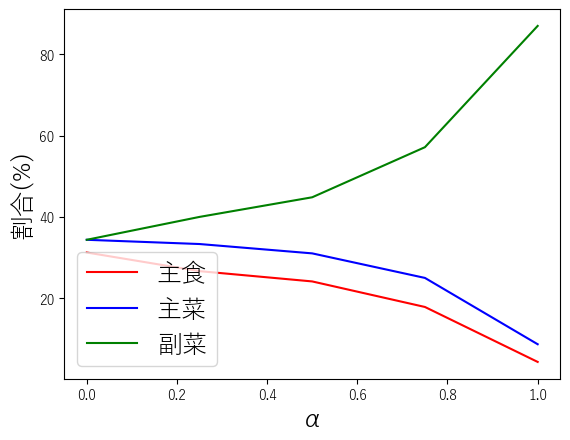

In [89]:
X = alpha_list

plt.xlabel("α", fontsize=18)
plt.ylabel("割合(%)",  fontsize=18)


#グラフプロット準備
plt.plot(X, Y_syusyoku, label="主食", color="red")
plt.plot(X, Y_syusai, label="主菜", color="blue")
plt.plot(X, Y_hukusai, label="副菜", color="green")


plt.legend(loc="lower left", fontsize=18)

#グラフ出力
plt.show()

In [90]:
Y_syusyoku = []
Y_syusai = []
Y_hukusai = []

# result_listの中身を表示
for alpha_index, alpha in enumerate(alpha_list):
    print("α = ", alpha)
    syusyoku = 0
    syusai = 0
    hukusai = 0
    goukei = 0
    for row in result_list[alpha_index]:
        print("料理名：", row[0], "主食：", row[1], "主菜：", row[2], "副菜：", row[3], "スコア：", row[8])
        syusyoku += float(row[1])
        syusai += float(row[2])
        hukusai += float(row[3])
        goukei += float(row[1]) + float(row[2]) + float(row[3])
        
        Y_syusyoku.append(syusyoku / goukei * 100)
        Y_syusai.append(syusai / goukei * 100)
        Y_hukusai.append(hukusai / goukei * 100)
    print("主食割合: ", round(syusyoku / goukei * 100, 2), "%")
    print("主菜割合: ", round(syusai / goukei * 100, 2), "%")
    print("副菜割合: ", round(hukusai / goukei * 100, 2), "%")
    print("\n")

α =  0.0
料理名： 大根サラダ 主食： 0.0 主菜： 0.0 副菜： 0.5 スコア： 1.0
料理名： ナポリタン 主食： 0.5 主菜： 0.5 副菜： 0.0 スコア： 0.15555555555555559
料理名： 揚げ出し豆腐 主食： 0.0 主菜： 0.5 副菜： 0.5 スコア： 0.4722222222222222
料理名： ペペロンチーノ 主食： 0.5 主菜： 0.0 副菜： 0.0 スコア： 0.2962962962962963
料理名： 焼きそば 主食： 0.5 主菜： 0.5 副菜： 0.5 スコア： 0.3666666666666667
料理名： 玉子焼き 主食： 0.0 主菜： 0.5 副菜： 0.0 スコア： 0.17901234567901234
料理名： 豆ごはん 主食： 0.5 主菜： 0.0 副菜： 0.5 スコア： 0.15555555555555559
料理名： 玉葱ステーキ 主食： 0.0 主菜： 0.0 副菜： 0.5 スコア： 1.0
料理名： さばの味噌煮フライパンで煮魚！ 主食： 0.0 主菜： 0.5 副菜： 0.0 スコア： 0.15555555555555559
料理名： おいなりさん 主食： 0.5 主菜： 0.0 副菜： 0.0 スコア： 0.10683760683760685
料理名： チャーハン 主食： 0.5 主菜： 0.5 副菜： 0.5 スコア： 0.24603174603174602
料理名： トッポギ 主食： 0.5 主菜： 0.5 副菜： 0.0 スコア： 0.15555555555555559
料理名： キャロット・ラペ 主食： 0.0 主菜： 0.0 副菜： 0.5 スコア： 1.0
料理名： 胡麻豆腐 主食： 0.0 主菜： 0.5 副菜： 0.5 スコア： 0.24603174603174602
料理名： パルメジャーノチーズのリゾット 主食： 0.5 主菜： 0.0 副菜： 0.0 スコア： 0.06172839506172839
料理名： ポモドーロ 主食： 0.5 主菜： 0.0 副菜： 0.5 スコア： 0.0851851851851852
料理名： 生姜焼き 主食： 0.0 主菜： 0.5 副菜： 0.0 スコア： 0.15555555555555559
料

In [91]:
# 前回のランキングから何位変化したかを表示

Y_syusyoku = []
Y_syusai = []
Y_hukusai = []

for alpha_index, alpha in enumerate(alpha_list):
    print("α = ", alpha)
    syusyoku = 0
    syusai = 0
    hukusai = 0
    goukei = 0
    if alpha_index == 0:
        for row_index, row in enumerate(result_list[alpha_index]):
            syusyoku += float(row[1])
            syusai += float(row[2])
            hukusai += float(row[3])
            goukei += float(row[1]) + float(row[2]) + float(row[3])
            print("料理名：", row[0], "今回の順位：", row_index + 1, "前回の順位：--", "順位変化：--", "主食：", round(syusyoku, 2), "主菜：", round(syusai, 2), "副菜：", round(hukusai, 2))
            
    else:
        for row_index, row in enumerate(result_list[alpha_index]):
            syusyoku += float(row[1])
            syusai += float(row[2])
            hukusai += float(row[3])
            found = False  # 料理が前回のリストに見つかったかどうかを示すフラグ
            for pre_row_index, pre_row in enumerate(result_list[alpha_index - 1]):
                if row[0] == pre_row[0]:
                    print("料理名：", row[0], "今回の順位：", row_index + 1, "前回の順位：", pre_row_index + 1, "順位変化：", pre_row_index - row_index, "主食：", round(syusyoku, 2), "主菜：", round(syusai, 2), "副菜：", round(hukusai, 2))
                    found = True  # 料理が見つかったことをマーク
                    break
            if not found:
                print("料理名：", row[0], "今回の順位：", row_index + 1, "前回の順位：--", "順位変化：--", "主食：", round(syusyoku, 2), "主菜：", round(syusai, 2), "副菜：", round(hukusai, 2))
    print("\n")

α =  0.0
料理名： 大根サラダ 今回の順位： 1 前回の順位：-- 順位変化：-- 主食： 0.0 主菜： 0.0 副菜： 0.5
料理名： ナポリタン 今回の順位： 2 前回の順位：-- 順位変化：-- 主食： 0.5 主菜： 0.5 副菜： 0.5
料理名： 揚げ出し豆腐 今回の順位： 3 前回の順位：-- 順位変化：-- 主食： 0.5 主菜： 1.0 副菜： 1.0
料理名： ペペロンチーノ 今回の順位： 4 前回の順位：-- 順位変化：-- 主食： 1.0 主菜： 1.0 副菜： 1.0
料理名： 焼きそば 今回の順位： 5 前回の順位：-- 順位変化：-- 主食： 1.5 主菜： 1.5 副菜： 1.5
料理名： 玉子焼き 今回の順位： 6 前回の順位：-- 順位変化：-- 主食： 1.5 主菜： 2.0 副菜： 1.5
料理名： 豆ごはん 今回の順位： 7 前回の順位：-- 順位変化：-- 主食： 2.0 主菜： 2.0 副菜： 2.0
料理名： 玉葱ステーキ 今回の順位： 8 前回の順位：-- 順位変化：-- 主食： 2.0 主菜： 2.0 副菜： 2.5
料理名： さばの味噌煮フライパンで煮魚！ 今回の順位： 9 前回の順位：-- 順位変化：-- 主食： 2.0 主菜： 2.5 副菜： 2.5
料理名： おいなりさん 今回の順位： 10 前回の順位：-- 順位変化：-- 主食： 2.5 主菜： 2.5 副菜： 2.5
料理名： チャーハン 今回の順位： 11 前回の順位：-- 順位変化：-- 主食： 3.0 主菜： 3.0 副菜： 3.0
料理名： トッポギ 今回の順位： 12 前回の順位：-- 順位変化：-- 主食： 3.5 主菜： 3.5 副菜： 3.0
料理名： キャロット・ラペ 今回の順位： 13 前回の順位：-- 順位変化：-- 主食： 3.5 主菜： 3.5 副菜： 3.5
料理名： 胡麻豆腐 今回の順位： 14 前回の順位：-- 順位変化：-- 主食： 3.5 主菜： 4.0 副菜： 4.0
料理名： パルメジャーノチーズのリゾット 今回の順位： 15 前回の順位：-- 順位変化：-- 主食： 4.0 主菜： 4.0 副菜： 4.0
料理名： ポモドーロ 今回の順位： 16 前回の順位：-- 順位変化：-- 主食： 4.5 主

In [92]:
# データを格納するためのリスト
data = []

for alpha_index, alpha in enumerate(alpha_list):
    alpha_data = []
    if alpha_index == 0:
        for row_index, row in enumerate(result_list[alpha_index]):
            alpha_data.append([row[0], row_index + 1, None, row[1], row[2], row[3]])
    else:
        for row_index, row in enumerate(result_list[alpha_index]):
            found = False  # 料理が前回のリストに見つかったかどうかを示すフラグ
            for pre_row_index, pre_row in enumerate(result_list[alpha_index - 1]):
                if row[0] == pre_row[0]:
                    alpha_data.append([row[0], row_index + 1, pre_row_index + 1, row[1], row[2], row[3]])
                    found = True  # 料理が見つかったことをマーク
                    break
            if not found:
                alpha_data.append([row[0], row_index + 1, None , row[1], row[2], row[3]])
    
    data.extend(alpha_data)

In [93]:
# 料理別のランキングを辞書に格納する
dish_data = {}
dish_data_2 = {}
for row in data:
    dish_name = row[0]
    if dish_name not in dish_data:
        dish_data[dish_name] = []
        dish_data_2[dish_name] = row[3:6]

In [94]:
j=0
for i in range(0, len(alpha_list)*10, 10):
    j=j+1
    k = int(i*R*0.1)
    for row in data[k:k+R]:
        dish_data[row[0]].append(row[1])
    for row2 in dish_data:
        if len(dish_data[row2]) < j:
            dish_data[row2].append(None)

c:\Users\Rintaro\OneDrive - 筑波大学\研究\system\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


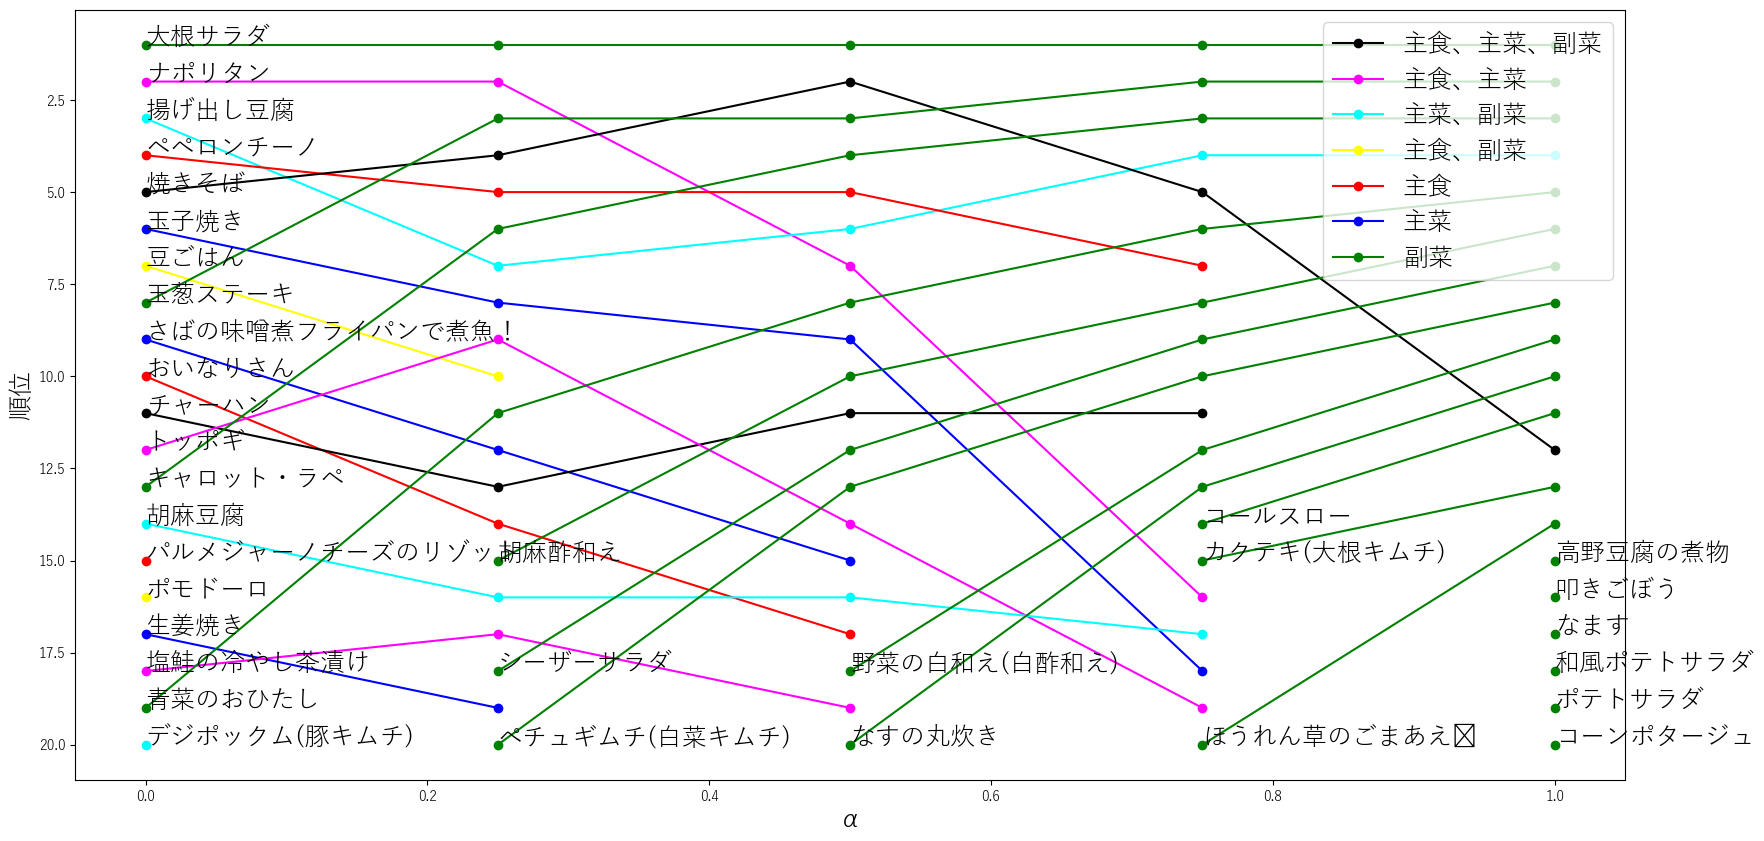

In [95]:
for j in dish_data_2:
    dish_data_2[j].append([])
    if dish_data_2[j][0] != 0:
        dish_data_2[j][3].append("主食")
    if dish_data_2[j][1] != 0:
        dish_data_2[j][3].append("主菜")
    if dish_data_2[j][2] != 0:
        dish_data_2[j][3].append("副菜")

# dish_dataを折れ線グラフにする
# グラフの描画
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

# プロットを作成
plt.plot([], [], label='主食、主菜、副菜', marker='o', color='Black')
plt.plot([], [], label='主食、主菜', marker='o', color='Magenta')
plt.plot([], [], label='主菜、副菜', marker='o', color='Cyan')
plt.plot([], [], label='主食、副菜', marker='o', color='Yellow')
plt.plot([], [], label='主食', marker='o', color='Red')
plt.plot([], [], label='主菜', marker='o', color='Blue')
plt.plot([], [], label='副菜', marker='o', color='Green')

# 凡例を表示
plt.legend(loc="upper right", fontsize=18)

# グラフのタイトルと軸ラベルを設定
#ax.set_title('料理別のランキングの推移', fontsize=20)
ax.set_xlabel('α', fontsize=18)
ax.set_ylabel('順位', fontsize=18)
ax.invert_yaxis()

# 描画するデータ
for dish_name in dish_data:
    if dish_data_2[dish_name][0] != 0 and dish_data_2[dish_name][1] != 0 and dish_data_2[dish_name][2] != 0:
        ax.plot(alpha_list, dish_data[dish_name], label=dish_name, marker='o', color='Black')
    elif dish_data_2[dish_name][0] != 0 and dish_data_2[dish_name][1] != 0:
        ax.plot(alpha_list, dish_data[dish_name], label=dish_name, marker='o', color='Magenta')
    elif dish_data_2[dish_name][1] != 0 and dish_data_2[dish_name][2] != 0:
        ax.plot(alpha_list, dish_data[dish_name], label=dish_name, marker='o', color='Cyan')
    elif dish_data_2[dish_name][0] != 0 and dish_data_2[dish_name][2] != 0:
        ax.plot(alpha_list, dish_data[dish_name], label=dish_name, marker='o', color='Yellow')
    elif dish_data_2[dish_name][0] != 0:
        ax.plot(alpha_list, dish_data[dish_name], label=dish_name, marker='o', color='Red')
    elif dish_data_2[dish_name][1] != 0:
        ax.plot(alpha_list, dish_data[dish_name], label=dish_name, marker='o', color='Blue')
    elif dish_data_2[dish_name][2] != 0:
        ax.plot(alpha_list, dish_data[dish_name], label=dish_name, marker='o', color='Green')

k = [next((i for i, x in enumerate(dish_data[dish_name]) if x), None) for dish_name in dish_data]

# グラフの始点にレシピ名を表示
for index, dish_name in enumerate(dish_data):
    #ax.text(alpha_list[k[index]], dish_data[dish_name][k[index]], dish_name +': '+ ', '.join(dish_data_2[dish_name][3]), fontsize=18)
    ax.text(alpha_list[k[index]], dish_data[dish_name][k[index]], dish_name, fontsize=18)

# グラフを表示
plt.show()


In [96]:
dish_data_2[dish_name][0]

0.0

In [97]:
# recipe_list[1:]に高野豆腐の煮物のデータがあるか確認
for row in recipe_list[1:]:
    if row[0] == '高野豆腐の煮物':
        print(row)

['高野豆腐の煮物', 0.0, 0.0, 0.5, -3.75, -3.5, -3.5, 10.0, 1.5]


In [98]:
# dish_dataのレシピ名の個数を表示する
dish_name_list = []
for index, dish_name in enumerate(dish_data):
    for row in recipe_list[1:]:
        if row[0] == dish_name:
            dish_name_list.append([dish_name, row[1], row[2], row[3]])
            print(index+1,"." , dish_name, row[1], row[2], row[3])

1 . 大根サラダ 0.0 0.0 0.5
2 . ナポリタン 0.5 0.5 0.0
3 . 揚げ出し豆腐 0.0 0.5 0.5
4 . ペペロンチーノ 0.5 0.0 0.0
5 . 焼きそば 0.5 0.5 0.5
6 . 玉子焼き 0.0 0.5 0.0
7 . 豆ごはん 0.5 0.0 0.5
8 . 玉葱ステーキ 0.0 0.0 0.5
9 . さばの味噌煮フライパンで煮魚！ 0.0 0.5 0.0
10 . おいなりさん 0.5 0.0 0.0
11 . チャーハン 0.5 0.5 0.5
12 . トッポギ 0.5 0.5 0.0
13 . キャロット・ラペ 0.0 0.0 0.5
14 . 胡麻豆腐 0.0 0.5 0.5
15 . パルメジャーノチーズのリゾット 0.5 0.0 0.0
16 . ポモドーロ 0.5 0.0 0.5
17 . 生姜焼き 0.0 0.5 0.0
18 . 塩鮭の冷やし茶漬け 0.5 0.5 0.0
19 . 青菜のおひたし 0.0 0.0 0.5
20 . デジポックム(豚キムチ) 0.0 0.5 0.5
21 . 胡麻酢和え 0.0 0.0 0.5
22 . シーザーサラダ 0.0 0.0 0.5
23 . ペチュギムチ(白菜キムチ) 0.0 0.0 0.5
24 . 野菜の白和え(白酢和え) 0.0 0.0 0.5
25 . なすの丸炊き 0.0 0.0 0.5
26 . コールスロー 0.0 0.0 0.5
27 . カクテキ(大根キムチ) 0.0 0.0 0.5
28 . ほうれん草のごまあえ	 0.0 0.0 0.5
29 . 高野豆腐の煮物 0.0 0.0 0.5
30 . 叩きごぼう 0.0 0.0 0.5
31 . なます 0.0 0.0 0.5
32 . 和風ポテトサラダ 0.0 0.0 0.5
33 . ポテトサラダ 0.0 0.0 0.5
34 . コーンポタージュ 0.0 0.0 0.5


In [99]:
dish_name_list

[['大根サラダ', 0.0, 0.0, 0.5],
 ['ナポリタン', 0.5, 0.5, 0.0],
 ['揚げ出し豆腐', 0.0, 0.5, 0.5],
 ['ペペロンチーノ', 0.5, 0.0, 0.0],
 ['焼きそば', 0.5, 0.5, 0.5],
 ['玉子焼き', 0.0, 0.5, 0.0],
 ['豆ごはん', 0.5, 0.0, 0.5],
 ['玉葱ステーキ', 0.0, 0.0, 0.5],
 ['さばの味噌煮フライパンで煮魚！', 0.0, 0.5, 0.0],
 ['おいなりさん', 0.5, 0.0, 0.0],
 ['チャーハン', 0.5, 0.5, 0.5],
 ['トッポギ', 0.5, 0.5, 0.0],
 ['キャロット・ラペ', 0.0, 0.0, 0.5],
 ['胡麻豆腐', 0.0, 0.5, 0.5],
 ['パルメジャーノチーズのリゾット', 0.5, 0.0, 0.0],
 ['ポモドーロ', 0.5, 0.0, 0.5],
 ['生姜焼き', 0.0, 0.5, 0.0],
 ['塩鮭の冷やし茶漬け', 0.5, 0.5, 0.0],
 ['青菜のおひたし', 0.0, 0.0, 0.5],
 ['デジポックム(豚キムチ)', 0.0, 0.5, 0.5],
 ['胡麻酢和え', 0.0, 0.0, 0.5],
 ['シーザーサラダ', 0.0, 0.0, 0.5],
 ['ペチュギムチ(白菜キムチ)', 0.0, 0.0, 0.5],
 ['野菜の白和え(白酢和え)', 0.0, 0.0, 0.5],
 ['なすの丸炊き', 0.0, 0.0, 0.5],
 ['コールスロー', 0.0, 0.0, 0.5],
 ['カクテキ(大根キムチ)', 0.0, 0.0, 0.5],
 ['ほうれん草のごまあえ\t', 0.0, 0.0, 0.5],
 ['高野豆腐の煮物', 0.0, 0.0, 0.5],
 ['叩きごぼう', 0.0, 0.0, 0.5],
 ['なます', 0.0, 0.0, 0.5],
 ['和風ポテトサラダ', 0.0, 0.0, 0.5],
 ['ポテトサラダ', 0.0, 0.0, 0.5],
 ['コーンポタージュ', 0.0, 0.0, 0.5]]

In [100]:

# リストをcsvファイルに書き込む
def write_csv(list, dish_name_list):
    DATE = datetime.now().strftime("%Y%m%d_%H%M%S")
    FILE_NAME = "./result/data_"+DATE+".csv"
    with open(FILE_NAME, 'w', newline='') as f:
        writer = csv.writer(f)
        # 評価対象のレシピ名を書き込む
        for row in dish_name_list:
            writer.writerow(row)
        # 空白行を書き込む
        writer.writerow([])
        # ランキングを書き込む
        for row in list:
            writer.writerows(row)
            writer.writerow([])
        f.close()

write_csv(result_list, dish_name_list)
